# Homework 5: spatial interpolation

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt

# Dataset preparation

In [ ]:
train_data = pd.read_csv('swissrain100.csv')
test_data = pd.read_csv('swissrain367.csv')

In [27]:
train_data.head(5)

,x,y,value,altitude
0,6.351499,46.544351,151,682
1,6.406433,46.710820,255,813
2,6.574735,46.737855,79,436
3,6.599386,46.904837,191,833
4,6.607163,46.835829,194,579


Each line contains four values: the x-coordinate, y-coordinate, value - corresponding to possibly rainfall and an altitude of the place.

In [28]:
train_data.describe()

,x,y,value,altitude
count,100.000000,100.000000,100.000000,100.000000
mean,8.396067,46.935516,180.150000,891.540000
std,0.962098,0.454626,116.681071,483.655784
min,6.351499,46.001432,10.000000,248.000000
25%,7.794263,46.530013,97.750000,516.500000
50%,8.589010,46.902851,141.000000,764.000000
75%,9.088685,47.359405,254.250000,1094.750000
max,10.116038,47.750880,585.000000,2418.000000


In [ ]:
X_train = train_data[['x', 'y', 'altitude']].values
y_train = train_data['value'].values

X_test = test_data[['x', 'y', 'altitude']].values
y_test = test_data['value'].values

# Check if differences in training and testing parts are statistically significant

In order to verify if train and test sample are similar, I conduct 2 statistical tests: Two-sample t-test and Wilcoxon rank-sum test for each variable present in the dataset.

## Two-sample T-test

In [30]:
from scipy.stats import ttest_ind

for column in ['x', 'y', 'value', 'altitude']:
    t_stat, p_value = ttest_ind(train_data[column], test_data[column])
    print(f"Two-Sample t-Test for {column}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print()

Two-Sample t-Test for x:
t-statistic: 2.1074
p-value: 0.0356

Two-Sample t-Test for y:
t-statistic: 0.3905
p-value: 0.6963

Two-Sample t-Test for value:
t-statistic: -0.4116
p-value: 0.6808

Two-Sample t-Test for altitude:
t-statistic: 0.9635
p-value: 0.3358



## Wilcoxon Rank-Sum Test

In [31]:
from scipy.stats import mannwhitneyu

for column in ['x', 'y', 'value', 'altitude']:
    u_stat, p_value = mannwhitneyu(train_data[column], test_data[column])
    print(f"Mann-Whitney U Test for {column}:")
    print(f"U-statistic: {u_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print()

Mann-Whitney U Test for x:
U-statistic: 20988.0000
p-value: 0.0275

Mann-Whitney U Test for y:
U-statistic: 18725.0000
p-value: 0.7543

Mann-Whitney U Test for value:
U-statistic: 17584.0000
p-value: 0.5223

Mann-Whitney U Test for altitude:
U-statistic: 19394.0000
p-value: 0.3831



As we can see, apart from the x-coordinate, the differences in both datasets are not statistically significant.

# Modelling

In order to find the optimal number of neighbors for both NN and IDW methods I conduct leave-one-out crossvalidation.

## Leave-one-out crossvalidation for number of neighbors in NN and IDW

In [87]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

def find_optimal_n_neighbors(X_train, y_train, model_type):
    mse_scores = []
    for n in range(1, len(X_train)):
        if model_type == 'NN':
            model = KNeighborsRegressor(n_neighbors=n)
        elif model_type == 'IDW':
            model = KNeighborsRegressor(n_neighbors=n, weights='distance')
        else:
            raise ValueError("Invalid model type. Choose either 'NN' or 'IDW'.")
        
        loo = LeaveOneOut()
        fold_mse_scores = []
        for train_index, test_index in loo.split(X_train):
            X_train_loo, X_test_loo = X_train[train_index], X_train[test_index]
            y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]
            model.fit(X_train_loo, y_train_loo)
            y_pred_loo = model.predict(X_test_loo)
            fold_mse_scores.append(mean_squared_error(y_test_loo, y_pred_loo))
        
        mse_scores.append(np.mean(fold_mse_scores))
    
    optimal_n = np.argmin(mse_scores)
    return optimal_n, mse_scores

In [83]:
def evaluate_model(X_train, y_train, X_test, y_test, model_type, n_neighbors=None):
    if model_type == 'NN':
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train[:, :2], y_train)
        y_pred = model.predict(X_test[:, :2])
    elif model_type == 'IDW':
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
        model.fit(X_train[:, :2], y_train)
        y_pred = model.predict(X_test[:, :2])
    elif model_type == 'Ordinary Kriging':
        model = OrdinaryKriging(X_train[:, 0], X_train[:, 1], y_train, variogram_model='linear')
        y_pred, _ = model.execute('points', X_test[:, 0], X_test[:, 1])
    elif model_type == 'Universal Kriging':
        model = UniversalKriging(X_train[:, 0], X_train[:, 1], y_train, variogram_model='linear', drift_terms=['specified'], specified_drift=[X_train[:, 2]])
        y_pred, _ = model.execute('points', X_test[:, 0], X_test[:, 1], specified_drift_arrays=[X_test[:, 2]])
    else:
        raise ValueError("Invalid model type. Choose from 'NN', 'IDW', 'Ordinary Kriging', or 'Universal Kriging'.")
    
    mse = mean_squared_error(y_test, y_pred)
    return model, y_pred, mse

In [84]:
optimal_n_nn, nn_mse_scores = find_optimal_n_neighbors(X_train, y_train, model_type='NN')
print(f"Optimal n_neighbors for NN: {optimal_n_nn}")

optimal_n_idw, idw_mse_scores = find_optimal_n_neighbors(X_train, y_train, model_type='IDW')
print(f"Optimal n_neighbors for IDW: {optimal_n_idw}")

Optimal n_neighbors for NN: 24
Optimal n_neighbors for IDW: 98


The optimal setting for NN is 24 neighbors and for IDW 98 neighbors respectively (so in IDW situation almost all training samples are taken into account). Now I am ready to fit the best models and analyze their mean-squared error.

## Best NN and IDW models

In [81]:
nn_model, y_pred_nn, mse_nn = evaluate_model(X_train, y_train, X_test, y_test, model_type='NN', n_neighbors=optimal_n_nn)
print(f"NN MSE: {mse_nn:.2f}")

idw_model, y_pred_idw, mse_idw = evaluate_model(X_train, y_train, X_test, y_test, model_type='IDW', n_neighbors=optimal_n_idw)
print(f"IDW MSE: {mse_idw:.2f}")

NN MSE: 9403.57
IDW MSE: 8459.00


## Kriging models

I also build 2 Kriging models, Ordinary and Universal Kriging respectively.

In [76]:
ok_model, y_pred_ok, mse_ok = evaluate_model(X_train, y_train, X_test, y_test, model_type='Ordinary Kriging')
print(f"Ordinary Kriging MSE: {mse_ok:.2f}")

uk_model, y_pred_uk, mse_uk = evaluate_model(X_train, y_train, X_test, y_test, model_type='Universal Kriging')
print(f"Universal Kriging MSE: {mse_uk:.2f}")

Ordinary Kriging MSE: 7086.92
Universal Kriging MSE: 7026.29


# Plots

In this section I investigate the differences in MSE along different interploation methods. Then I analyze the heatmap showing how grid of popints is predicted by each method.

## Prepare predictions for grid of points

In [77]:
x_min, x_max = np.min(X_test[:, 0]), np.max(X_test[:, 0])
y_min, y_max = np.min(X_test[:, 1]), np.max(X_test[:, 1])
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
xy_grid = np.vstack((x_grid.ravel(), y_grid.ravel())).T


z_nn = nn_model.predict(xy_grid)
z_idw = idw_model.predict(xy_grid)
z_ok, _ = ok_model.execute('points', xy_grid[:, 0], xy_grid[:, 1])
z_uk, _ = ok_model.execute('points', xy_grid[:, 0], xy_grid[:, 1])

## MSE comparison

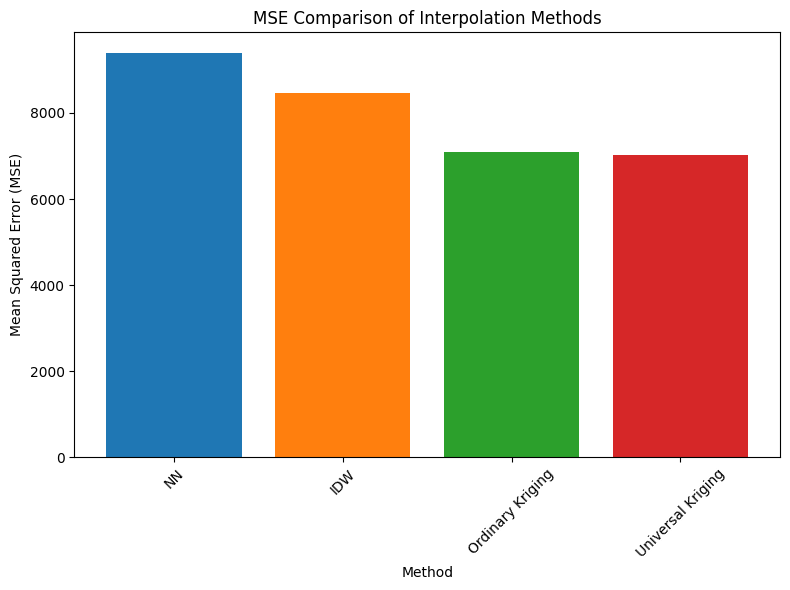

In [78]:
mse_data = pd.DataFrame({'Method': ['NN', 'IDW', 'Ordinary Kriging', 'Universal Kriging'],
                         'MSE': [mse_nn, mse_idw, mse_ok, mse_uk]})

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(8, 6))
plt.bar(mse_data['Method'], mse_data['MSE'], color=colors)
plt.xlabel('Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison of Interpolation Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The best model appears to be Universal Kriging along with Ordinary Kriging with the lowest MSE. Methods based on nearest neighbor strategy prove to be significantly worse.

## Plot rainfall heatmaps

C:\Users\jan20\AppData\Local\Temp\ipykernel_28520\4158171122.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


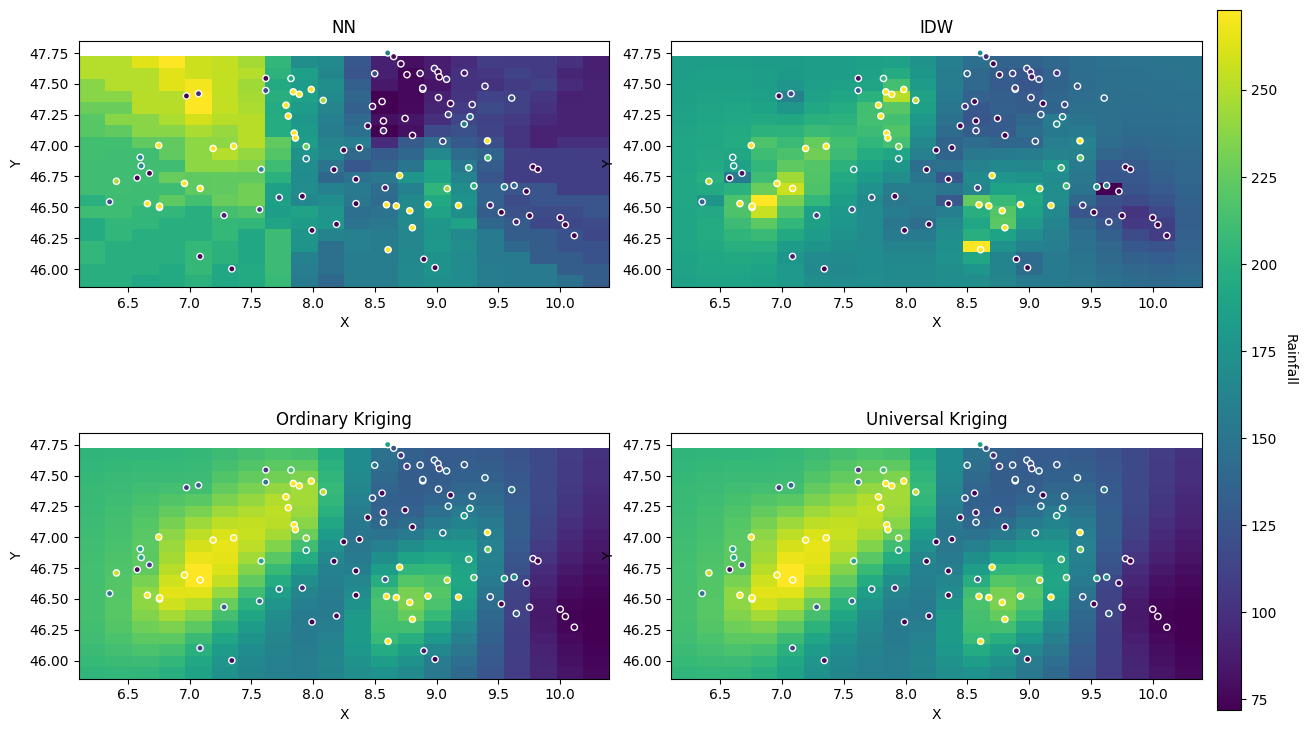

In [79]:
methods = ['NN', 'IDW', 'Ordinary Kriging', 'Universal Kriging']
z_values = [z_nn, z_idw, z_ok, z_uk]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(right=0.5, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])

for i, (method, z) in enumerate(zip(methods, z_values)):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(z.reshape(x_grid.shape), extent=[x_min, x_max, y_min, y_max], cmap='viridis', origin='lower')
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=20, edgecolor='white', vmin=im.get_array().min(), vmax=im.get_array().max())
    ax.set_title(method)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Rainfall', rotation=-90, va="bottom")

plt.tight_layout()
plt.show()